# Multi-Factor Prediction of Mental Illness Incidence Rates
**Quinn Bischoff, Eric Matteucci, Rajat Singh, Daniel Velasco**

# Phase I

## Introduction

Behavioural and emotional well-being is integral to the development of societies around the world. However, the rates of incidence of mental health disorders are on the rise in some places around the globe, while others are declining. Our goal is to predict these incidence rates using linear regression and deep learning methods on a rich data set.

Using a combination of data sets that include news headlines, financial indicators, and population distributions and indices, to generate a prediction of incidence of disorders such as depression or anxiety, and deaths by mental health. To this end, news headlines will be preprocessed using natural language processing (NLP)—specifically, sentiment analysis. The score, in conjunction with the aforementioned datasets, will be used to generate a linear regression model and a neural network.

## Phase I Goal
The aim of this phase is to collect and join required data from various sources, preprocess it, and make necessary modifications for the application of different machine learning techniques. This involves generating relevant visualizations and setting up a pipeline with tested operations.

Two data collection methods will be employed:
1. Web scraping: Retrieval of news headlines for sentiment analysis.
2. CSV formatted data: data obtained from the WHO, CIA and other relevant sources.


## Setup

#### Imports

In [1]:
%matplotlib inline

from bs4 import BeautifulSoup
from functools import reduce
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
import matplotlib.gridspec as grid
import numpy as np
import os
import pandas as pd
import requests
import seaborn



#### Constants
This section contains constants to be used throughout this notebook. Comments separate different sections.

In [2]:
# column names
COL_COUNTRY = 'country'
COL_GDP = 'GDP'
COL_HDI = 'HDI'
COL_POPULATION_DENSITY = 'population density'
COL_UNEMPLOYMENT = 'unemployment rate'
COL_URBAN_DENSITY = 'urban density (%)'
COL_YEAR = 'year'
COL_NEWS_TEMPLATE = 'news{}'

TARGETS = [
    'Bipolar disorder (%)',
    'Eating disorders (%)',
    'Anxiety disorders (%)',
    'Drug use disorders (%)',
    'Depression (%)',
    'Alcohol use disorders (%)',
]

FEATURES = [
    COL_GDP,
    COL_HDI,
    COL_POPULATION_DENSITY,
    COL_UNEMPLOYMENT,
    COL_URBAN_DENSITY,
]

# directories and filenames
DIR_DATA = 'data'
DIR_FINANCIAL = os.path.join(DIR_DATA, 'financial')
DIR_HDI = os.path.join(DIR_DATA, 'human_development_index')
DIR_MENTAL_HEALTH = os.path.join(DIR_DATA, 'mental_health')
DIR_NEWS = os.path.join(DIR_DATA, 'news')
DIR_POPULATION = os.path.join(DIR_DATA, 'population')

FILENAME_DISORDERS = 'prevalence-by-mental-and-substance-use-disorder.csv'
FILENAME_GDP = 'wrldbnk_gdp.csv'
FILENAME_HDI = 'hdi.csv'
FILENAME_NEWS_HEADLINES = 'news_headlines.csv'
FILENAME_POPULATION_DENSITY = 'wrldbnk_pop_dnst.csv'
FILENAME_UNEMPLOYMENT = 'wrldbnk_unemployment.csv'
FILENAME_URBAN_DENSITY = 'wrldbnk_urban_pop.csv'

# Years
DATE_START = '2005'
DATE_END = '2018'

DATE_RANGE = [str(i) for i in range(2005, 2018)]
DATE_NEWS_FROM = ['{}-02-02', '{}-05-05', '{}-07-07', '{}-11-11']
DATE_NEWS_TO = ['{}-03-03', '{}-06-06','{}-08-08', '{}-12-12']


# country values
SELECTED_COUNTRIES = [
    'south africa',
    'kenya',
    'china',
    'taiwan',
    'japan',
    'south korea',
    'india',
    'pakistan',
    'indonesia',
    'philippines',
    'singapore',
    'thailand',
    'canada',
    'united kingdom',
    'ireland',
    'scotland',
    'australia',
    'new zealand',
    'united states',
]


COUNTRIES_DICT = {
    'australia' : 'australia',
    'canada' : 'canada',
    'china' : 'asia/china',
    'india' : 'asia/india',
    'indonesia' : 'asia/southeast/indonesia',
    'ireland' : 'europe/ireland',
    'japan' : 'asia/japan',
    'kenya' : 'africa/kenya',
    'new zealand' : 'new_zealand',
    'pakistan' : 'asia/pakistan',
    'philippines' : 'asia/philippines',
    'scotland' : 'europe/scotland',
    'singapore' : 'asia/singapore',
    'south africa' : 'africa/south_africa',
    'south korea' : 'asia/south_korea',
    'taiwan' : 'asia/taiwan',
    'thailand' : 'asia/thailand',
    'united kingdom' : 'europe/uk',
    'united states' : 'us'
}


# News URL
URL = 'https://newslookup.com/{}?&ut={}&l=1&utto={}'

### Utility Methods
This section contains methods that load and preprocess data.

In [3]:
def load_data_frame(file_name, path, sep=None):
    """
    Loads data from specified path and name, returns a dataframe
    """
    file_path = os.path.join(path, file_name)
    if not sep:
        return pd.read_csv(file_path)
    return pd.read_csv(file_path, sep=sep)


def load_mental_health_data():
    """
    Loads mental health data, and performs basic preprocessing operations:
        - columns renamed appropriately for compatibility
        - selected countries are filtered
        - unnecessary columns are dropped
    """
    mental_df = load_data_frame(
        FILENAME_DISORDERS,
        DIR_MENTAL_HEALTH
    )

    mental_df.rename(columns={'Entity': COL_COUNTRY, 'Year': COL_YEAR}, inplace=True)
    mental_df.drop(labels='Code', axis=1, inplace=True)
    mental_df[COL_COUNTRY] = mental_df[COL_COUNTRY].str.lower()
    mental_df = mental_df[mental_df[COL_COUNTRY].isin(SELECTED_COUNTRIES)]
    return mental_df


def load_world_bank_data(filename, directory, value):
    """
    Loads World Bank data, and performs basic preprocessing operations:
        - columns renamed appropriately for compatibility
        - selected countries are filtered
        - unnecessary columns are dropped
        - non-numerical values are replaced with NaN or transformed appropriately
    """
    df = load_data_frame(
        filename,
        directory
    )
    df.rename(columns={'Country Name': COL_COUNTRY}, inplace=True)
    df.drop(['Indicator Name', 'Indicator Code', 'Country Code'], axis=1, inplace = True)
    df = df.replace('..', np.NaN)
    df.loc[:,1:] = df.iloc[:, 1:].apply(pd.to_numeric)
    df[COL_COUNTRY] = df[COL_COUNTRY].str.lower()
    df = df.replace('korea, rep.', 'south korea')
    df = df.loc[df[COL_COUNTRY].isin(SELECTED_COUNTRIES)]

    columns = df.columns
    country_index = columns.get_loc(COL_COUNTRY)
    start_index = columns.get_loc(DATE_START)
    end_index = columns.get_loc(DATE_END)
    df = df.iloc[:, np.r_[country_index, start_index:end_index]]

    # Reshape the dataframe to structure `country|year|value`
    df = pd.melt(
        df,
        id_vars=COL_COUNTRY,
        var_name=COL_YEAR,
        value_name=value
    )
    df[COL_YEAR] = df[COL_YEAR].apply(pd.to_numeric)
    df = df.sort_values([COL_COUNTRY, COL_YEAR])
    df.reset_index(inplace=True, drop=True)
    df.dropna(axis=0, inplace=True)
    return df


def load_hdi_data():
    """
    Loads human development index (HDI) data, and performs basic preprocessing operations:
        - columns are renamed for compatibility
        - selected countries are filtered
        - unnecessary columns are dropped
    """
    hdi_df = load_data_frame(
        FILENAME_HDI,
        DIR_HDI
    )

    hdi_df = hdi_df.dropna(how='all', axis=1)
    hdi_df.drop('HDI Rank (2017)', axis=1, inplace=True)
    hdi_df.rename(columns={'Country': COL_COUNTRY, 'Year': COL_YEAR}, inplace=True)
    hdi_df[COL_COUNTRY] = hdi_df[COL_COUNTRY].str.lower().str.strip()
    hdi_df = hdi_df[hdi_df[COL_COUNTRY].isin(SELECTED_COUNTRIES)]
    hdi_df = hdi_df.reset_index(drop=True)
    hdi_df.loc[:,1:] = hdi_df.iloc[:,1:].apply(pd.to_numeric)

    # Reshape the dataframe to structure `country|year|value`
    hdi_df = pd.melt(
        hdi_df,
        id_vars=[COL_COUNTRY],
        var_name=COL_YEAR,
        value_name=COL_HDI
    )

    hdi_df[COL_YEAR] = hdi_df[COL_YEAR].apply(pd.to_numeric)
    hdi_df = hdi_df.drop(hdi_df[hdi_df.year < int(DATE_START)].index)
    hdi_df = hdi_df.drop(hdi_df[hdi_df.year > int(DATE_END)].index)
    return hdi_df



## Web Scraping: News Headlines

News headlines are scraped from NewsLookup.com. Each country's headlines from the years 2005 to 2017 are searched and scraped.
In phase 2, sentiment analysis will be run on these headlines.

In [7]:
news_columns = [COL_NEWS_TEMPLATE.format(i) for i in range(200)]
news_columns.insert(0, COL_COUNTRY)
news_columns.insert(0, COL_YEAR)
headlines_df = pd.DataFrame(columns=news_columns)

def scrape_news_headlines():
    """
    Scrapes the web for news headlines and loads them into a pandas dataframe for export to csv.
    """
    # Get year headlines for each country
    for country_key, country_value in COUNTRIES_DICT.items():
        country_headlines = list()

        for year in DATE_RANGE:
            yearly_headlines = list()
            for i in range(len(DATE_NEWS_FROM)):
                # Format the from and to date and create the news link query
                from_date = DATE_NEWS_FROM[i].format(year)
                to_date = DATE_NEWS_TO[i].format(year)
                news_link = URL.format(country_value, from_date, to_date)

                response = requests.get(news_link)
                soup = BeautifulSoup(response.content, 'html.parser')

                # Parse the headlines from the html response
                headlines = [l.get_text() for l in soup.find_all('a', class_="link")]

                # Append the headlines for the country
                yearly_headlines.extend(headlines)

            # Only append the headlines if some exist
            if len(yearly_headlines) > 0:
                columns = [COL_NEWS_TEMPLATE.format(i) for i in range(len(yearly_headlines))]
                columns.insert(0, COL_COUNTRY)
                columns.insert(0, COL_YEAR)

                yearly_headlines.insert(0, country_key)
                yearly_headlines.insert(0, year)

                year_df = pd.DataFrame([yearly_headlines], columns=columns)

                headlines_df = pd.concat([headlines_df, year_df], sort=False)

    headlines_df.reset_index(inplace=True, drop=True)

    file_path = os.path.join(DIR_NEWS, FILENAME_NEWS_HEADLINES)
    headlines_df.to_csv(file_path, sep='|')
    return headlines_df


## Data Loading & Integration
The following code block loads csv datasets into dataframes. The following data is collected:
1. Population density per country over a time period.
2. Percentage of the population living in urban areas over a time period.
3. GDP per country over a time period.
4. Unemployment rate per country over a time period.
5. Mental illness rates per country over a time period.
6. Human Development Index of countries over a time period.

The data is then joined into a single table, related by country name and year.

In [9]:
# Population Density
population_df = load_world_bank_data(FILENAME_POPULATION_DENSITY, DIR_POPULATION, COL_POPULATION_DENSITY)

# Urban Population Density
urban_df = load_world_bank_data(FILENAME_URBAN_DENSITY, DIR_POPULATION, COL_URBAN_DENSITY)

# GDP
gdp_df = load_world_bank_data(FILENAME_GDP, DIR_FINANCIAL, COL_GDP)

# Unemployment
unemployment_df = load_world_bank_data(FILENAME_UNEMPLOYMENT, DIR_FINANCIAL, COL_UNEMPLOYMENT)

# HDI data
hdi_df = load_hdi_data()

#Scrape the headlines. Uncomment this if you have not yet scraped news headlines
scrape_news_headlines()

# News Headlines.
#news_df = load_data_frame(FILENAME_NEWS_HEADLINES, DIR_NEWS, sep='|')

# Mental health data
mental_df = load_mental_health_data()



# Join density dataframes, gdp, and unemployment
data_frames_list = [population_df, urban_df, gdp_df, unemployment_df, hdi_df, mental_df]
joined_df = reduce(lambda left,right: pd.merge(left,right,on=[COL_COUNTRY, COL_YEAR],how='inner'), data_frames_list)

#joined_with_news_df = pd.merge(right=joined_df, left=news_df, on=[COL_COUNTRY, COL_YEAR],how='inner')


## Visualizations

`pair_plot_with_parameters` is used to display each data feature against each other for all years. The different colors
represent different countries. The purpose of this visualization is to gain insight of the kind
of data we are manipulating and how it relates to each other. In other words, it is a visual approach to
elucidating the different correlations.

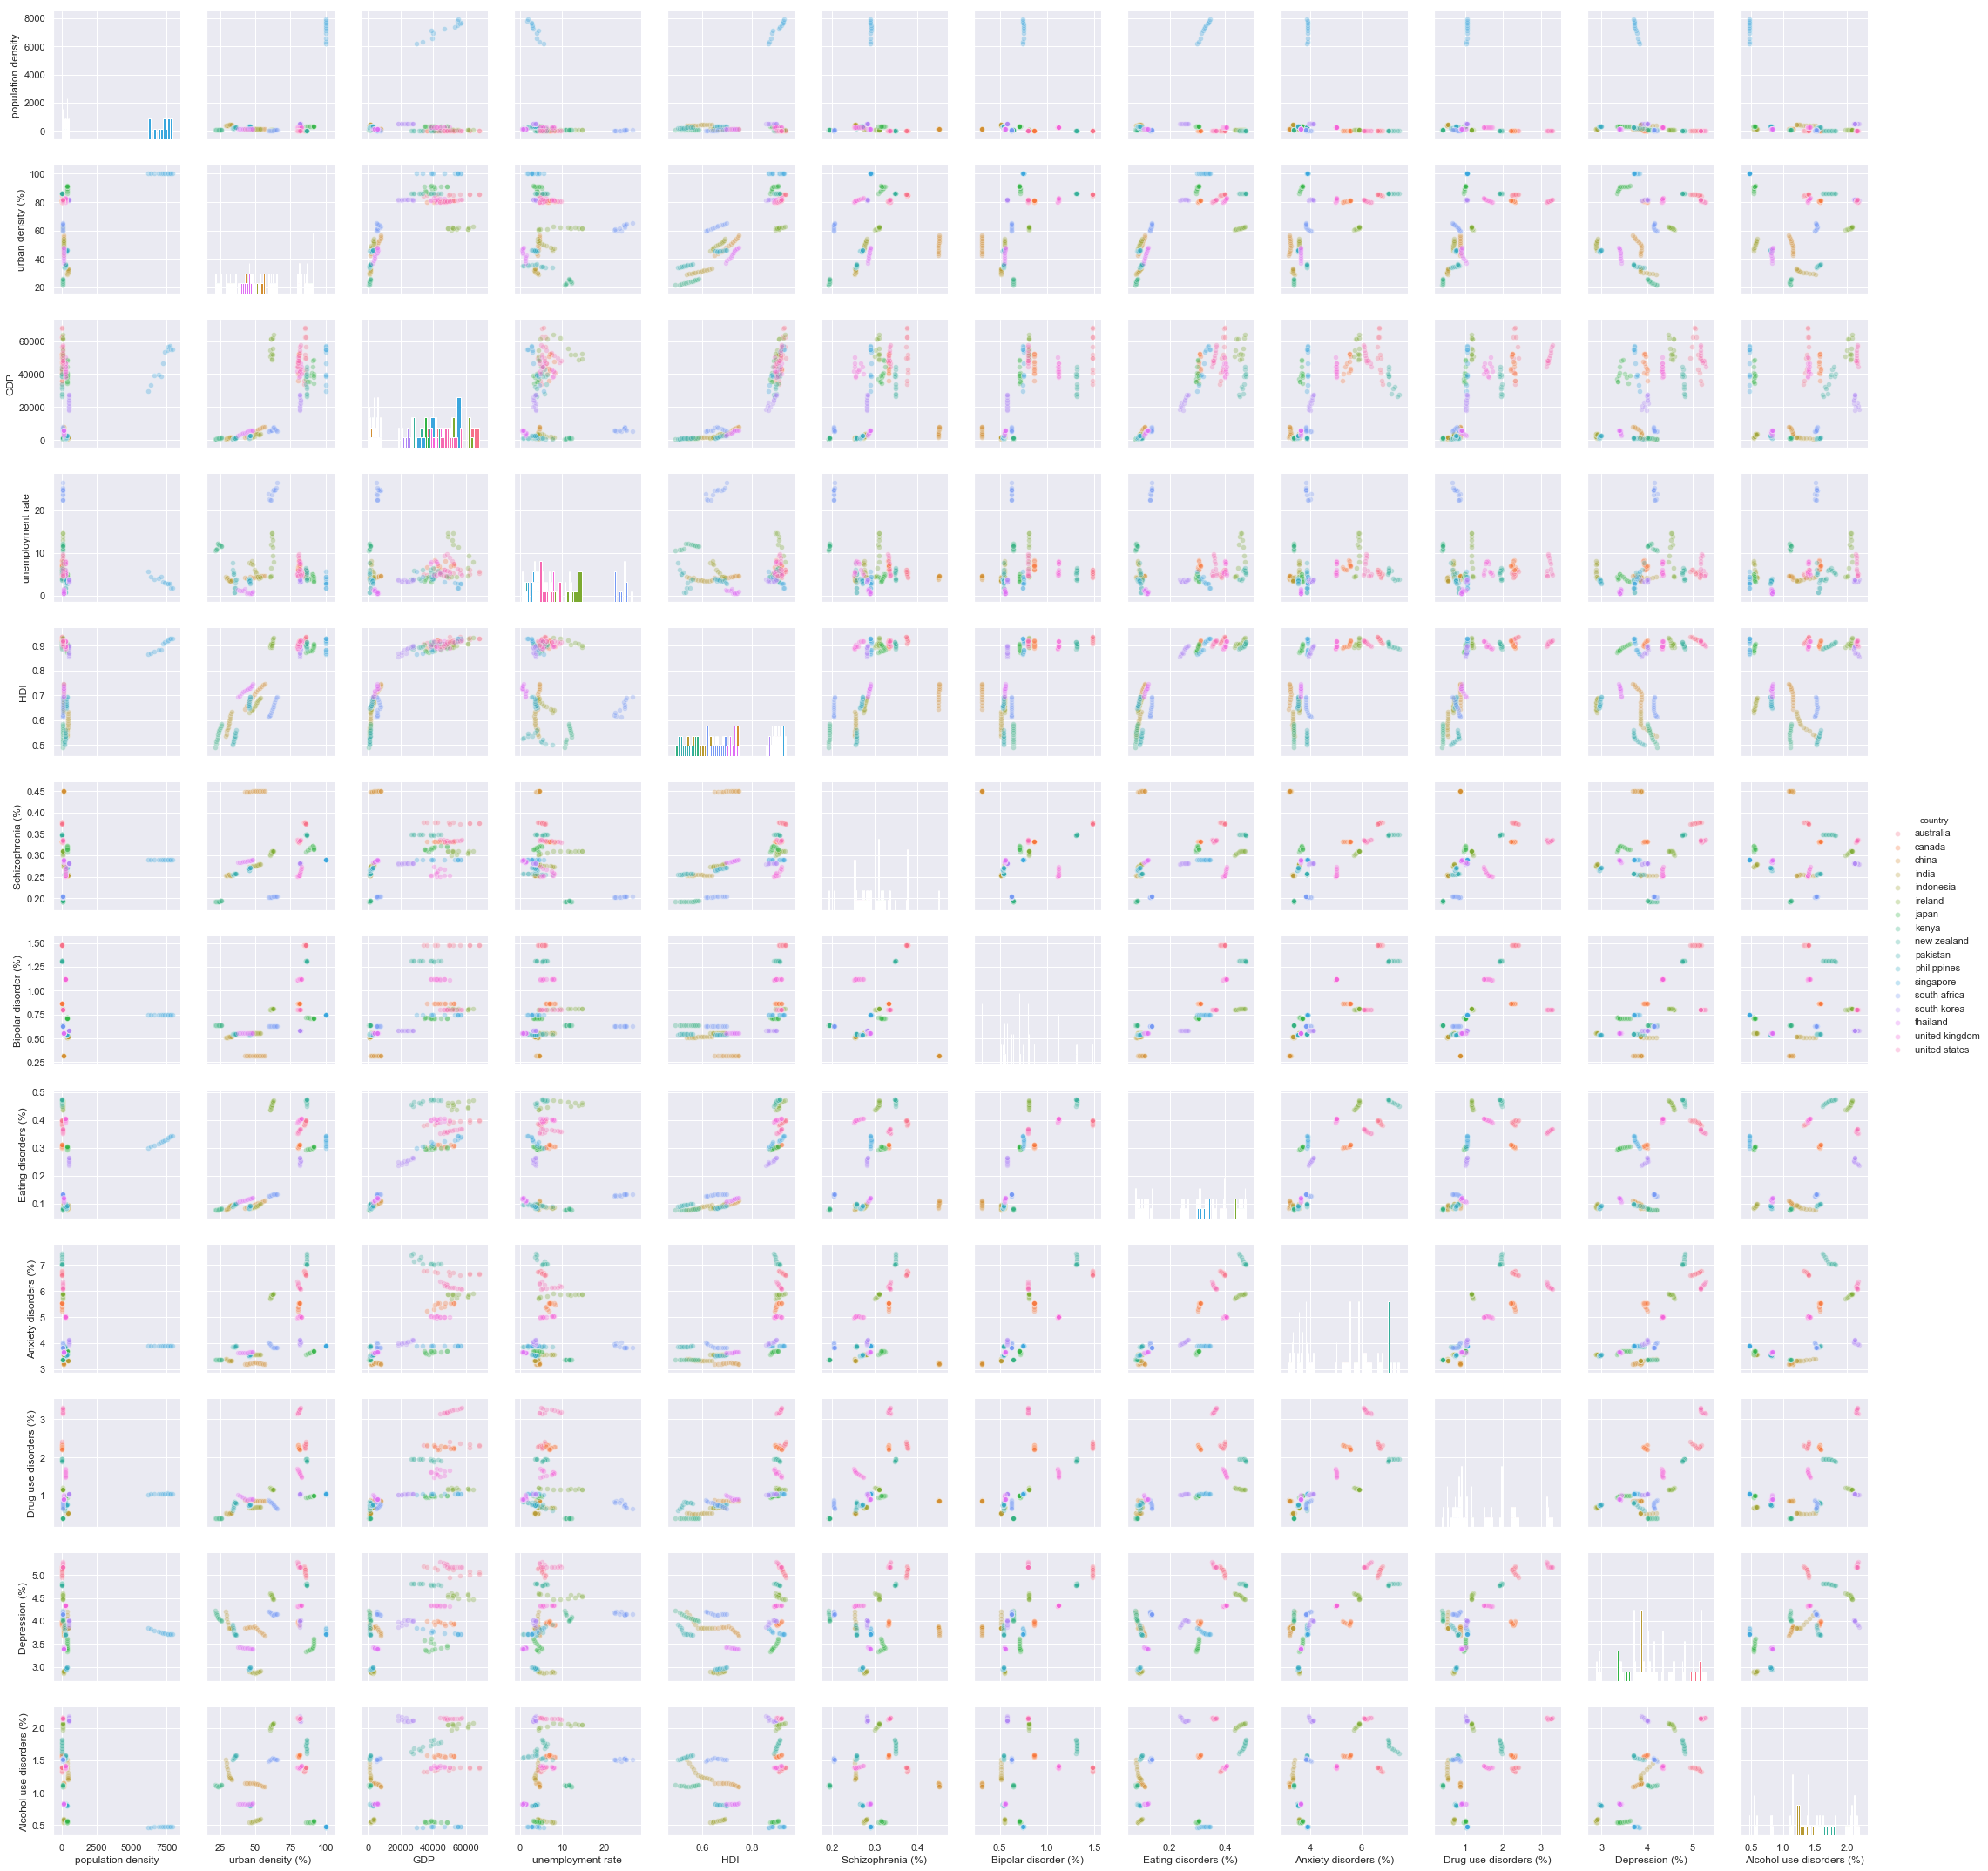

In [10]:
def pair_plot_with_parameters(data_frame):
    """
    This function plots all features of a data frame against one another.
    The diagonal is a histogram of feature values.
    """
    parameters = data_frame.columns.tolist()
    parameters.remove(COL_COUNTRY)
    parameters.remove(COL_YEAR)
    seaborn.set()
    with seaborn.color_palette("Dark2", 8):
        seaborn.pairplot(
            data_frame,
            vars=parameters,
            kind='scatter',
            hue=COL_COUNTRY,
            diag_kind='hist',
            dropna=True,
            plot_kws=dict(alpha=0.3),
        )

pair_plot_with_parameters(joined_df)

<br>

`scatter_3d_plot`: finally, we would like to visualize smaller sets of features in their relation to mental health disorders. This way, if there are any obvious plane differences, we can use to our advantage in the next phase of the project when we select training attributes.

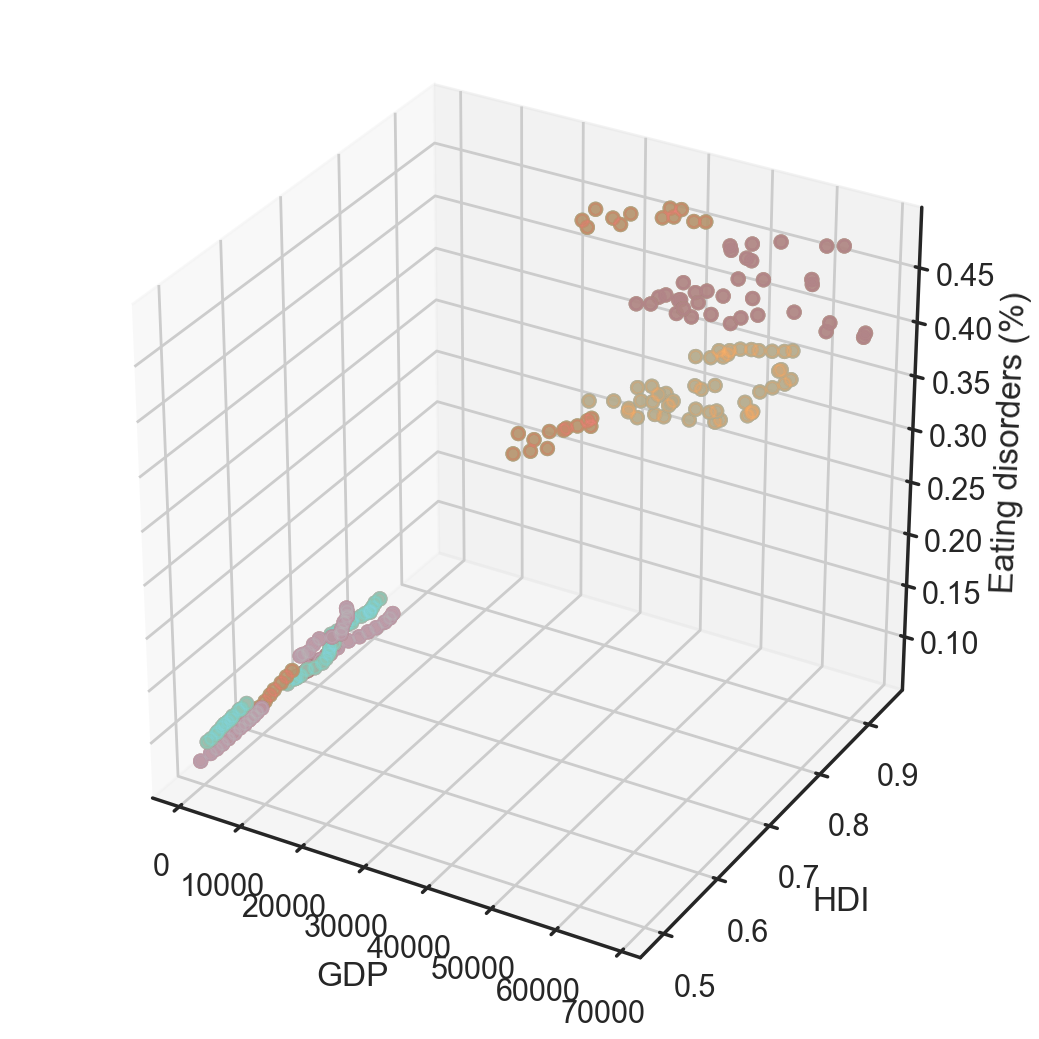

In [11]:
seaborn.set(style='white', palette='tab20')
def plot_3d_scatter_maps(data_frame, x_axis, y_axis, z_axis):

    figure = plt.figure(figsize=(5,5), dpi=200)
    the_plot = Axes3D(figure)

    the_plot.set_xlabel(x_axis)
    the_plot.set_ylabel(y_axis)
    the_plot.set_zlabel(z_axis)

    for country in data_frame[COL_COUNTRY]:
        the_plot.scatter(data_frame.loc[data_frame[COL_COUNTRY] == country, x_axis],
                         data_frame.loc[data_frame[COL_COUNTRY] == country, y_axis],
                         data_frame.loc[data_frame[COL_COUNTRY] == country, z_axis],
                         alpha=0.2)

    the_plot.set_xlabel(x_axis)
    the_plot.set_ylabel(y_axis)
    the_plot.set_zlabel(z_axis)

    plt.show()

plot_3d_scatter_maps(joined_df, COL_GDP, COL_HDI, 'Eating disorders (%)')

<br>

`Pandas.corr`: since we are mostly interested in predicting mental health disorders, we need a numerical approach to examine how much each attribute of our data set correlates with each mental health disorder rate.

In [12]:
correlation_matrix = joined_df.corr()
print(correlation_matrix['Bipolar disorder (%)'], '\n')
print(correlation_matrix['Eating disorders (%)'], '\n')
print(correlation_matrix['Anxiety disorders (%)'], '\n')
print(correlation_matrix['Drug use disorders (%)'], '\n')
print(correlation_matrix['Depression (%)'], '\n')
print(correlation_matrix['Alcohol use disorders (%)'], '\n')

year                         0.000901
population density          -0.037168
urban density (%)            0.598145
GDP                          0.682857
unemployment rate            0.014862
HDI                          0.633066
Schizophrenia (%)            0.226514
Bipolar disorder (%)         1.000000
Eating disorders (%)         0.797425
Anxiety disorders (%)        0.860013
Drug use disorders (%)       0.651908
Depression (%)               0.673787
Alcohol use disorders (%)    0.259621
Name: Bipolar disorder (%), dtype: float64 

year                         0.041591
population density           0.128786
urban density (%)            0.801793
GDP                          0.923092
unemployment rate           -0.042849
HDI                          0.899003
Schizophrenia (%)            0.369439
Bipolar disorder (%)         0.797425
Eating disorders (%)         1.000000
Anxiety disorders (%)        0.850286
Drug use disorders (%)       0.701490
Depression (%)               0.678691
Alcoh

<br>

Finally, we using correlation data found above, we plot the best correlated features against respective mental health rates.

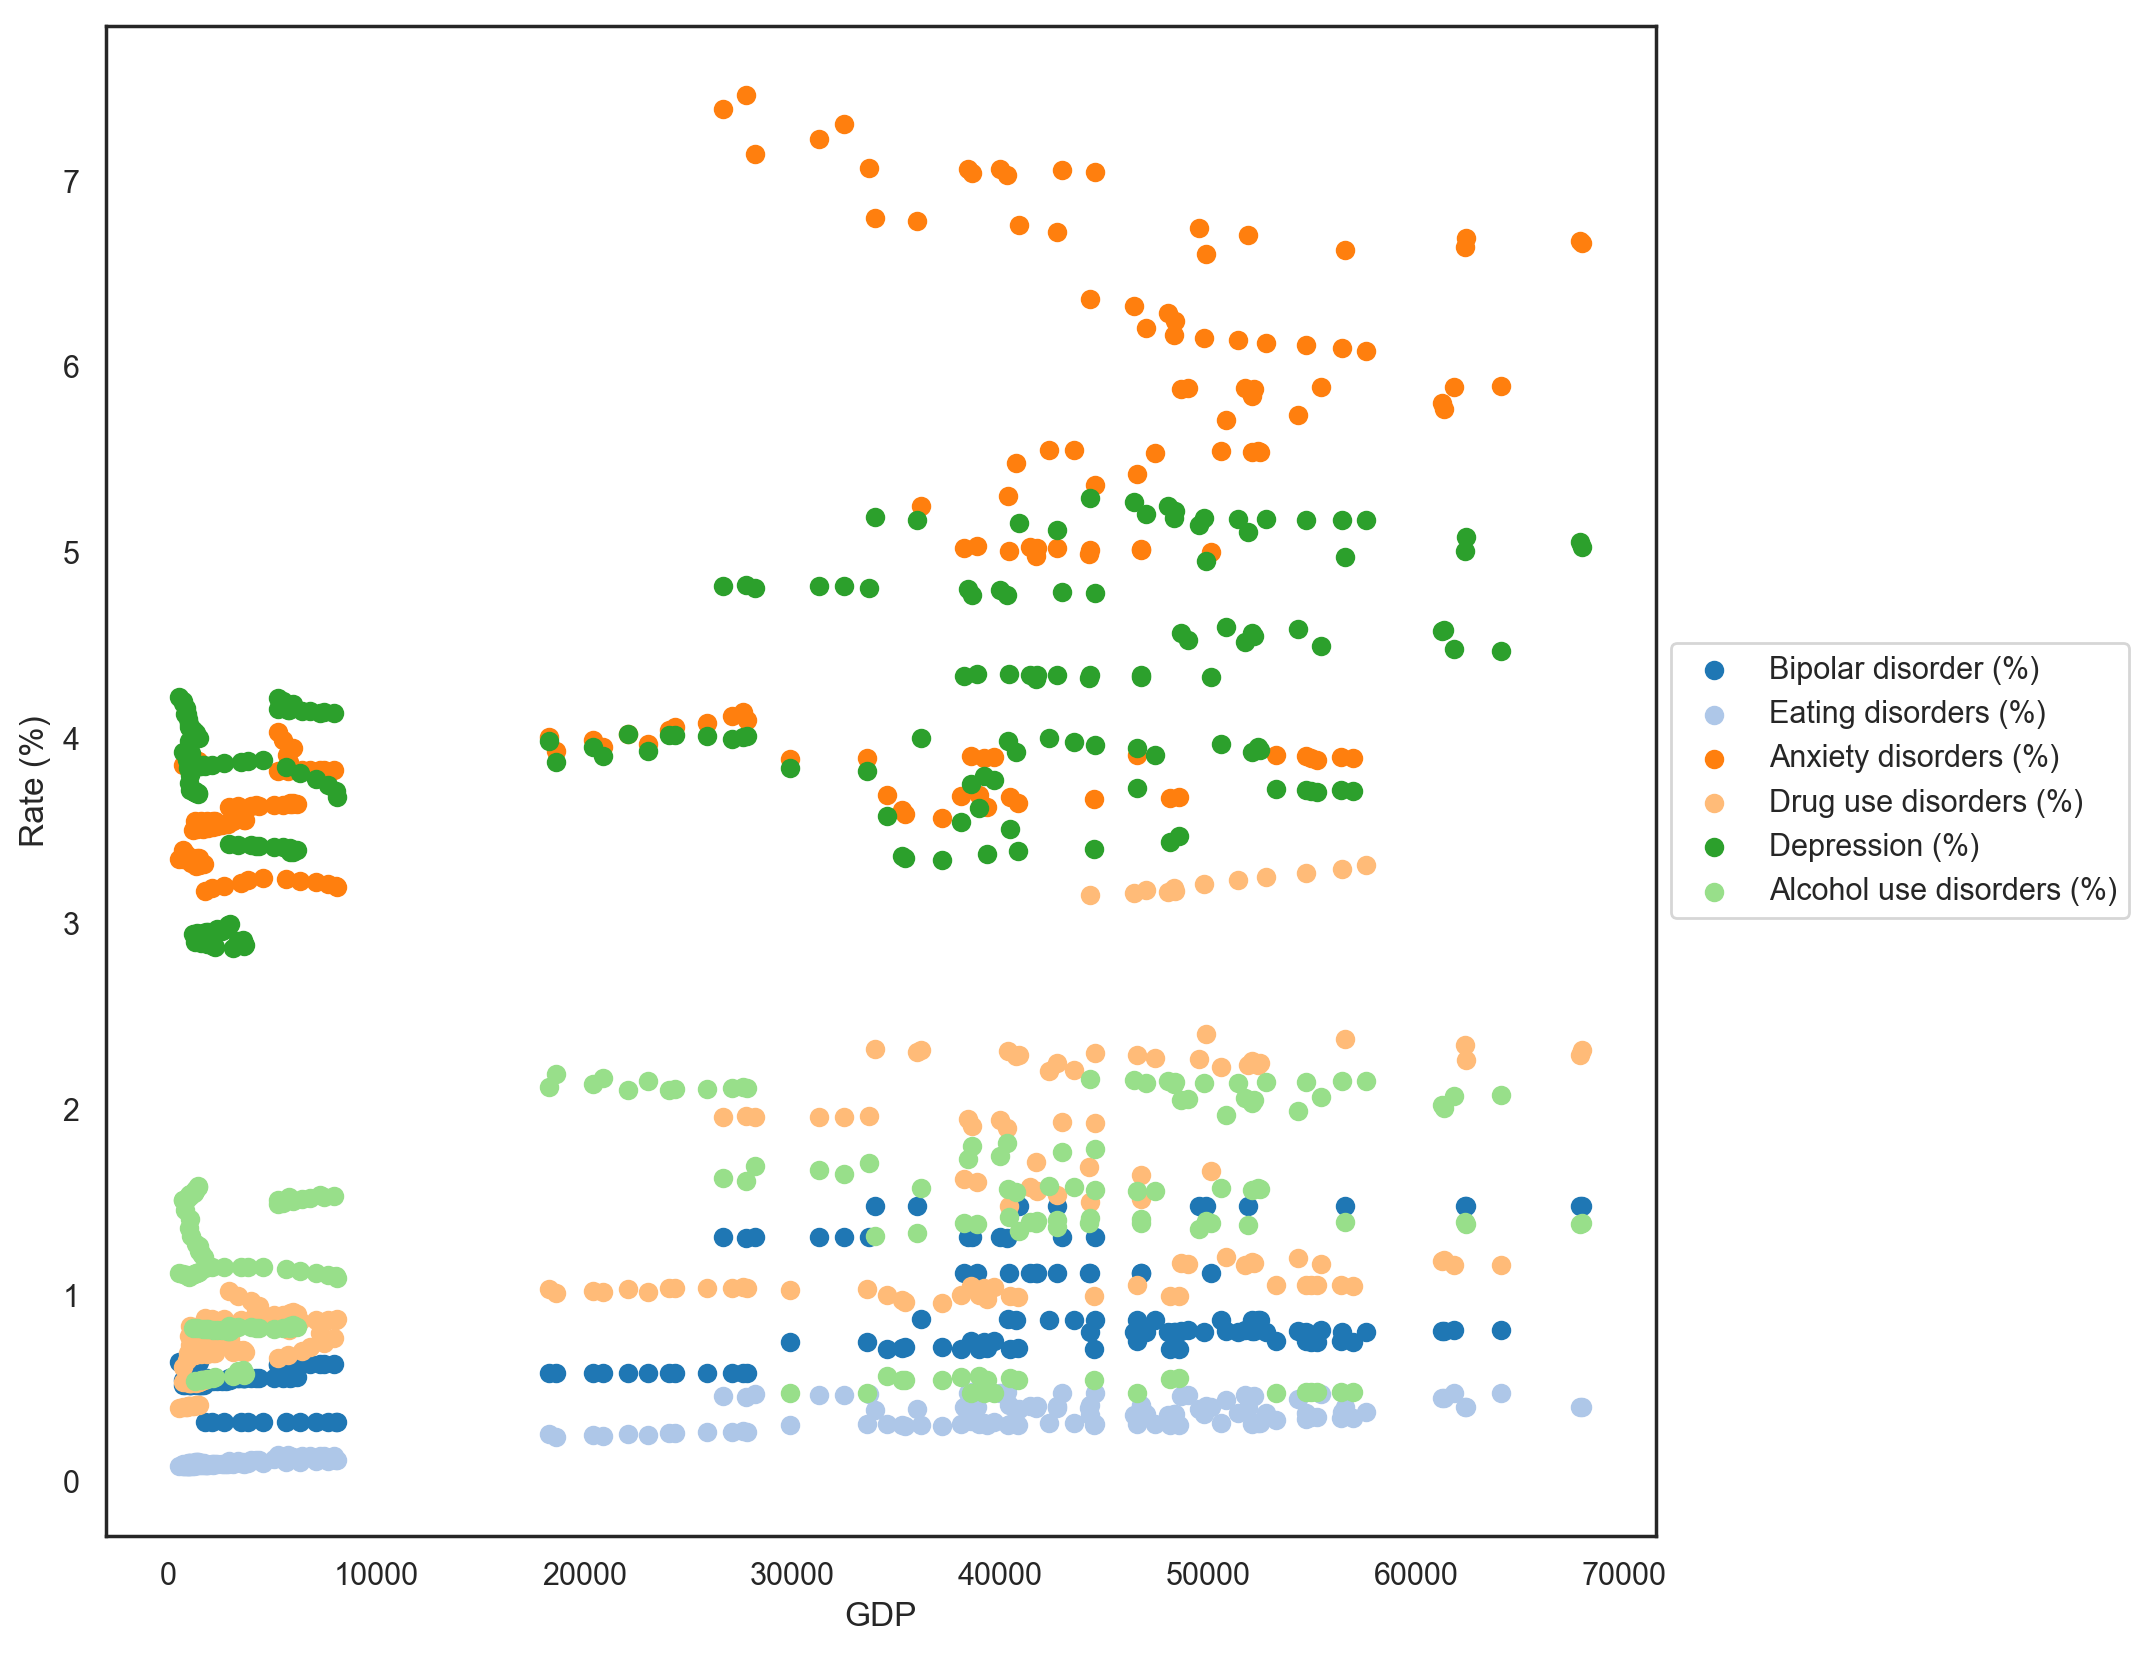

In [13]:
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(10,10), dpi=200)
gr = grid.GridSpec(len(TARGETS), 1)
gr.update(hspace=0.001)
alpha = 0.4


x = joined_df[COL_GDP].values

for rate in TARGETS:
    y = joined_df[rate],
    ax.scatter(
        x,
        y,
        label=rate,
    )
ax.set_ylabel('Rate (%)')
ax.set_xlabel(COL_GDP)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()